In [2]:
import csv
import random
import os
import pymc as pm
from pymc import do, observe
import pandas as pd
import numpy as np
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from pytensor import tensor as pt
import pickle as pkl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import itertools as it
import country_converter as cc
import math
from sklearn.linear_model import LinearRegression
import graphviz

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Burke data

In [3]:
data = pd.read_csv("../data/burke/data/input/GrowthClimateDataset.csv")
indices_to_drop = []
no_nan_cols = ["UDel_temp_popweight","UDel_precip_popweight","growthWDI"]
for index, row in enumerate(data.itertuples()):
    if any(np.isnan(getattr(row,col)) for col in no_nan_cols):
        indices_to_drop.append(index)
data = data.drop(indices_to_drop).reset_index(drop=True)
test_data = pd.read_csv("../data/burke/data/input/GrowthClimateDataset_test.csv")
train_data = pd.read_csv("../data/burke/data/input/GrowthClimateDataset_train.csv")
grad_effect_columns = train_data.loc[:, train_data.columns.str.startswith(('_y'))]
ordered_country_list = list(dict.fromkeys(train_data.iso))
enc = OrdinalEncoder()
enc.fit(np.array(ordered_country_list).reshape(-1,1))
data["encoded_iso_id"] = [int(val) for val in enc.transform(np.array(data.iso_id).reshape(-1,1))]

/tmp/ipykernel_3690/3775520672.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data["encoded_iso_id"] = [int(val) for val in enc.transform(np.array(data.iso_id).reshape(-1,1))]


# Make dataset withholding random data points

In [80]:
random.seed(1)
indices_to_drop = []
all_years = set(data.year)
for year in all_years:
    year_rows = data.loc[data.year == year]
    year_row_indices = list(year_rows.index)
    drop_from_this_year = random.sample(year_row_indices, 6)
    for index in drop_from_this_year:
        indices_to_drop.append(index)
withheld_rows = data.iloc[indices_to_drop]
data_len_before = len(data)
data_mod = data.drop(indices_to_drop)
data_mod = data_mod.reset_index(drop=True)
print(f"Removed {data_len_before - len(data_mod)} rows.")

Removed 300 rows.


In [83]:
data_mod.to_csv("../data/burke/data/input/GrowthClimateDataset_train.csv")

In [84]:
pd.DataFrame(withheld_rows).to_csv("../data/burke/data/input/GrowthClimateDataset_test.csv")

# Delta Method

In [144]:
in_range = 0
out_range = 0
lowers, uppers = [], []
real_y = []

yhat = pd.read_csv("../data/burke/data/input/burke_stdp_pred.csv")
# yhat = pd.read_csv("../data/burke/data/input/bootstrap/burke_bootstrap_stdp.csv")
for row in enumerate(yhat.itertuples()):
    lower = row[1].lower
    upper = row[1].upper
    real_y.append(row[1].growthwdi)
    if lower <= real_y[-1] and upper >= real_y[-1]:
        in_range += 1
    else:
        out_range += 1
    lowers.append(lower), uppers.append(upper)

print(in_range / len(yhat))
print(out_range / len(yhat))

0.51
0.49


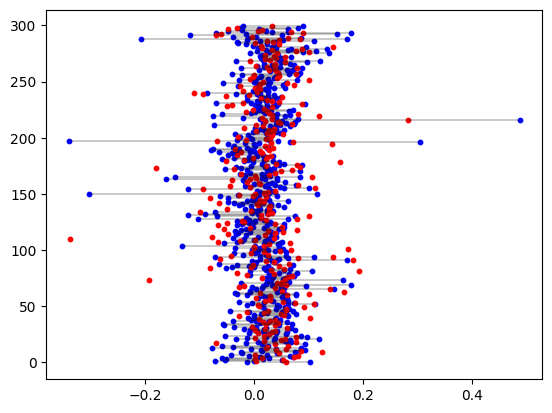

In [145]:
plt.scatter(lowers, list(range(len(yhat))), color="blue", s=10)
plt.scatter(uppers, list(range(len(yhat))), color="blue", s=10)
plt.scatter(real_y, list(range(len(yhat))), color="red", s=10)
for index in range(len(yhat)):
    plt.plot([lowers[index],uppers[index]],[index,index],'k-', linewidth=.3)
plt.show()

In [2]:
# https://stats.stackexchange.com/questions/178475/confidence-interval-for-vertex-of-quadratic-model-transforming-parameters-estim
coef1 = .0127183
coef2 = -.0004871
temp_variance =	.0000143
temp2_variance = .0000000140
temp_temp2_cov = -.000000376

vertex_variance = .25 * pow(coef1/coef2,2) * ((temp_variance/pow(coef1,2))+(temp2_variance/pow(coef2,2))-(2*(temp_temp2_cov/(coef1*coef2))))
vertex = coef1 / (-2 * coef2)
print(vertex, vertex - 1.96 * np.sqrt(vertex_variance), vertex + 1.96 * np.sqrt(vertex_variance))

13.05512215150893 8.927266935659443 17.18297736735842


# Bayesian model

In [33]:
# model = pd.read_pickle('../models/nature_reproduction/burke-reproduction-mcmc-fixed-effects-grad-effects-deterministic-observed-withheld.pkl')
model = pd.read_pickle('../models/nature_reproduction/burke-reproduction-mcmc-fixed-effects-grad-effects-deterministic-observed-hierarchical-std-error-withheld.pkl')
trace = model["trace"]

In [34]:
bayes_coef1 = trace.posterior.temp_gdp_coef.data.flatten()
bayes_coef2 = trace.posterior.temp_sq_gdp_coef.data.flatten()
bayes_coef3 = trace.posterior.precip_gdp_coef.data.flatten()
bayes_coef4 = trace.posterior.precip_sq_gdp_coef.data.flatten()
intercept = trace.posterior.gdp_intercept.data.flatten()
grad_coefs = np.transpose(np.vstack(trace.posterior.grad_effect_coefs.data))
country_coefs = np.transpose(np.vstack(trace.posterior.country_coefs.data))
year_coefs = np.transpose(np.vstack(trace.posterior.year_coefs.data))

In [35]:
# unscale all model parameters

bayes_coef1 = (bayes_coef1 * np.std(train_data.growthWDI) / np.std(train_data.UDel_temp_popweight)) - (2 * (bayes_coef2 * np.mean(train_data.UDel_temp_popweight * np.std(train_data.growthWDI)) / np.square(np.std(train_data.UDel_temp_popweight))))
bayes_coef2 = (bayes_coef2 * np.std(train_data.growthWDI) / np.square(np.std(train_data.UDel_temp_popweight)))
bayes_coef3 = (bayes_coef3 * np.std(train_data.growthWDI) / np.std(train_data.UDel_precip_popweight)) - (2 * (bayes_coef4 * np.mean(train_data.UDel_precip_popweight * np.std(train_data.growthWDI)) / np.square(np.std(train_data.UDel_precip_popweight))))
bayes_coef4 = (bayes_coef4 * np.std(train_data.growthWDI)) / np.square(np.std(train_data.UDel_precip_popweight))

intercept = (intercept * np.std(train_data.growthWDI)) + np.mean(train_data.growthWDI) - ((bayes_coef1 * np.mean(train_data.UDel_temp_popweight)) + (bayes_coef2 * np.square(np.mean(train_data.UDel_temp_popweight))) + (bayes_coef3 * np.mean(train_data.UDel_precip_popweight)) + (bayes_coef4 * np.square(np.mean(train_data.UDel_precip_popweight))))
for i in range(len(grad_coefs)):
    grad_coefs[i] = (grad_coefs[i] * np.std(train_data.growthWDI))
for i in range(len(country_coefs)):
    country_coefs[i] = country_coefs[i] * np.std(train_data.growthWDI)
for i in range(len(year_coefs)):
    year_coefs[i] = year_coefs[i] * np.std(train_data.growthWDI)

In [38]:
yhat = []
real_y = []
min_year = min(train_data.year)
grad_effect_column_names = list(grad_effect_columns)
for row in test_data.iterrows():
# for row in train_data.iterrows():
    temp = row[1].UDel_temp_popweight
    precip = row[1].UDel_precip_popweight
    country = row[1].iso
    year = row[1].year
    real_y.append(row[1].growthWDI)
    if country == ordered_country_list[0]:
        country_effect = 0
    else:
        country_effect = country_coefs[ordered_country_list.index(country)-1]
    if year - min_year == 0:
        year_effect = 0
    else:
        year_effect = year_coefs[year - min_year -1]
    predict_gdp = (
        temp*bayes_coef1 + 
        np.square(temp)*bayes_coef2 +
        precip*bayes_coef3 +
        np.square(precip)*bayes_coef4 +
        country_effect +
        year_effect +
        intercept
    )
    grad_effect = 0
    for i, effect in enumerate(grad_effect_column_names):
        grad_effect += row[1][effect]* grad_coefs[i]
    predict_gdp += grad_effect
    yhat.append(sorted(predict_gdp))

In [40]:
in_range, out_range = 0, 0
lowers, uppers = [], []
for index, prediction in enumerate(yhat):
    interval = np.quantile(prediction,[.05,.95])
    lowers.append(interval[0])
    uppers.append(interval[1])
    if real_y[index] >= interval[0] and real_y[index] <= interval[1]:
        in_range += 1
    else:
        out_range += 1
print(in_range/len(yhat))
print(out_range/len(yhat))

0.61
0.39


(0.0028258472135698626, 0.09564053460970416)


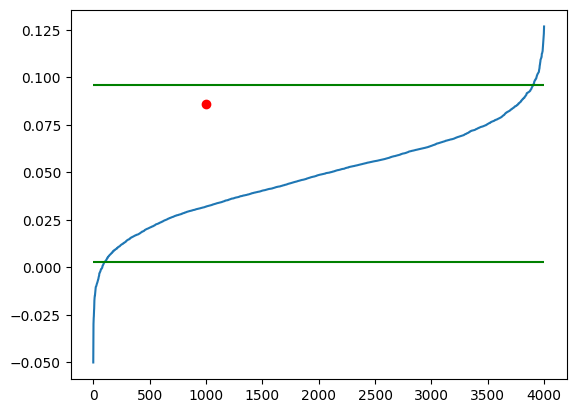

In [233]:
index = 10
plt.plot(yhat[index])
plt.plot(1000,real_y[index],'ro')
interval = (yhat[index][int(len(yhat[index])*.025)],yhat[index][int(len(yhat[index])*.975)])
print(interval)
plt.hlines(interval[0],0,4000,color="green")
plt.hlines(interval[1],0,4000,color="green")

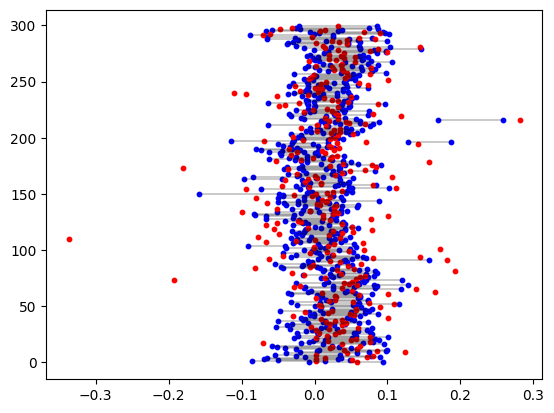

In [41]:
plt.scatter(lowers, list(range(len(yhat))), color="blue", s=10)
plt.scatter(uppers, list(range(len(yhat))), color="blue", s=10)
plt.scatter(real_y, list(range(len(yhat))), color="red", s=10)
for index in range(len(yhat)):
    plt.plot([lowers[index],uppers[index]],[index,index],'k-', linewidth=.3)
plt.show()

# Bootstrap from Stata

In [44]:
bootstrap_reps = pd.read_csv("../data/burke/data/input/bootstrap/burke_stata_bootstrap_replications.csv")
column_names = list(bootstrap_reps.iloc[0])
for index, column in enumerate(column_names):
    if "year" in column:
        column_names[index] = column.split("[")[1].split(".")[0].replace("b","")
    elif "isoxtim" in column:
        column_names[index] = column.split("[")[1].split("]")[0].replace("o.","")
    elif "encoded_iso_id" in column:
        column_names[index] = ordered_country_list[int(column.split("[")[1].split(".")[0].replace("b",""))]
bootstrap_reps.iloc[0] = column_names
bootstrap_reps.to_csv("../data/burke/data/input/bootstrap/burke_stata_bootstrap_replications_better_column_names.csv")

/tmp/ipykernel_3902/3439787215.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,26

In [64]:
bootstrap_reps = pd.read_csv("../data/burke/data/input/bootstrap/burke_stata_bootstrap_replications_better_column_names.csv", header=1)

# optionally remove all rows with any missing value
indices_to_drop = []
no_nan_cols = ["coef1"]
for index, row in enumerate(bootstrap_reps.itertuples()):
    if any(np.isnan(getattr(row,col)) for col in no_nan_cols):
        indices_to_drop.append(index)
bootstrap_reps = bootstrap_reps.drop(indices_to_drop)

yhat = []
real_y = []
min_year = min(train_data.year)
grad_effect_column_names = list(grad_effect_columns)
for row in test_data.iterrows():
    temp = row[1].UDel_temp_popweight
    precip = row[1].UDel_precip_popweight
    country = row[1].iso
    year = row[1].year
    real_y.append(row[1].growthWDI)
    predict_gdp = (
        temp*bootstrap_reps.coef1 + 
        np.square(temp)*bootstrap_reps.coef2 +
        precip*bootstrap_reps.coef3 +
        np.square(precip)*bootstrap_reps.coef4 +
        bootstrap_reps[country] +
        bootstrap_reps[str(year)] +
        bootstrap_reps["intercept"]
    )
    grad_effect = 0
    for i, effect in enumerate(grad_effect_column_names):
        grad_effect += row[1][effect]* bootstrap_reps[effect.lower()]
    predict_gdp += grad_effect
    yhat.append(sorted(predict_gdp))

In [65]:
in_range, out_range = 0, 0
lowers, uppers = [], []
for index, prediction in enumerate(yhat):
    interval = np.quantile(prediction,[.05,.95])
    lowers.append(interval[0])
    uppers.append(interval[1])
    if real_y[index] >= interval[0] and real_y[index] <= interval[1]:
        in_range += 1
    else:
        out_range += 1
print(in_range/len(yhat))
print(out_range/len(yhat))

0.4866666666666667
0.5133333333333333


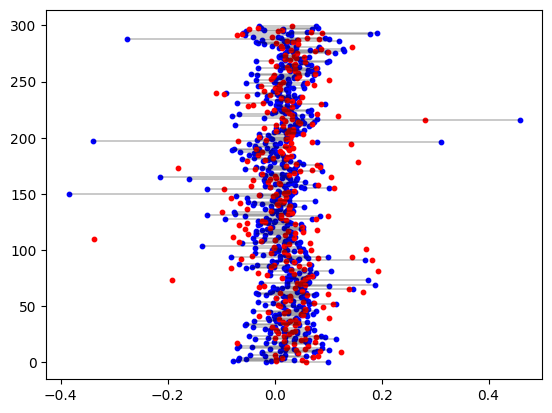

In [66]:
plt.scatter(lowers, list(range(len(yhat))), color="blue", s=10)
plt.scatter(uppers, list(range(len(yhat))), color="blue", s=10)
plt.scatter(real_y, list(range(len(yhat))), color="red", s=10)
for index in range(len(yhat)):
    plt.plot([lowers[index],uppers[index]],[index,index],'k-', linewidth=.3)
plt.show()

# Bootstrap from Burke code

In [42]:
bootstrap_reps_dir = "../data/burke/data/input/bootstrap/replications/"
bootstrap_reps = {"coef1":[],"coef2":[],"coef3":[],"coef4":[],"intercept":[]}
for year in range(1961,2011):
    bootstrap_reps[str(year)] = []
for iso_id in ordered_country_list:
    bootstrap_reps[iso_id] = []
for grad_effect in range(0,202):
    bootstrap_reps["_yi_isoxtim_"+str(grad_effect)] = []
    bootstrap_reps["_y2_isoxtim_"+str(grad_effect)] = []

def map_to_coef_name(input):
    if input == '="udel_temp_popweight"':
        return "coef1"
    elif input == '="udel_temp_popweight_2"':
        return "coef2"
    elif input == '="udel_precip_popweight"':
        return "coef3"
    elif input == '="udel_precip_popweight_2"':
        return "coef4"
    elif "year" in input:
        return input.split(".")[0].split("\"")[1]
    elif "isoxtim" in input:
        return input.split("\"")[1]
    elif "encoded_iso_id" in input:
        return ordered_country_list[int(input.split(".")[0].split("\"")[1])]
    elif "cons" in input:
        return "intercept"
    else:
        assert False, input

iters = 0
for file in os.listdir(bootstrap_reps_dir):
    if file != ".ipynb_checkpoints":
        iters += 1
        rep = pd.read_csv(bootstrap_reps_dir + file)
        for row in rep.itertuples():
            if any(x in row._1 for x in ["year", "isoxtim", "encoded_iso_id", "udel", "cons"]):
                bootstrap_reps[map_to_coef_name(row._1)].append(float(row._2.split("\"")[1].split("\"")[0].replace("*","")))
        for key, list in bootstrap_reps.items():
            assert len(list) == iters or len(list) == iters - 1, (key, list)
            if len(list) == iters - 1:
                bootstrap_reps[key].append(np.NaN)

pd.DataFrame.from_dict(bootstrap_reps).to_csv("../data/burke/data/input/bootstrap/replications/burke_code_bootstrap_all_reps.csv")

In [13]:
bootstrap_reps = pd.read_csv("../data/burke/data/input/bootstrap/replications/burke_code_bootstrap_all_reps.csv")

yhat = []
real_y = []
min_year = min(train_data.year)
grad_effect_column_names = list(grad_effect_columns)
for row in test_data.iterrows():
    temp = row[1].UDel_temp_popweight
    precip = row[1].UDel_precip_popweight
    country = row[1].iso
    year = row[1].year
    real_y.append(row[1].growthWDI)
    nan_indices = [index for index, row in enumerate(bootstrap_reps.iterrows()) if np.isnan(row[1][country])]
    bootstrap_reps_temp = bootstrap_reps.drop(nan_indices)
    predict_gdp = (
        temp*bootstrap_reps_temp.coef1 + 
        np.square(temp)*bootstrap_reps_temp.coef2 +
        precip*bootstrap_reps_temp.coef3 +
        np.square(precip)*bootstrap_reps_temp.coef4 +
        bootstrap_reps_temp[country] +
        bootstrap_reps_temp[str(year)] +
        bootstrap_reps_temp["intercept"]
    )
    grad_effect = 0
    for i, effect in enumerate(grad_effect_column_names):
        grad_effect += row[1][effect]* bootstrap_reps_temp[effect.lower()]
    predict_gdp += grad_effect
    yhat.append(sorted(predict_gdp))

In [14]:
in_range, out_range = 0, 0
lowers, uppers = [], []
for index, prediction in enumerate(yhat):
    interval = np.quantile(prediction,[.05,.95])
    lowers.append(interval[0])
    uppers.append(interval[1])
    if real_y[index] >= interval[0] and real_y[index] <= interval[1]:
        in_range += 1
    else:
        out_range += 1
print(in_range/len(yhat))
print(out_range/len(yhat))

0.21333333333333335
0.7866666666666666


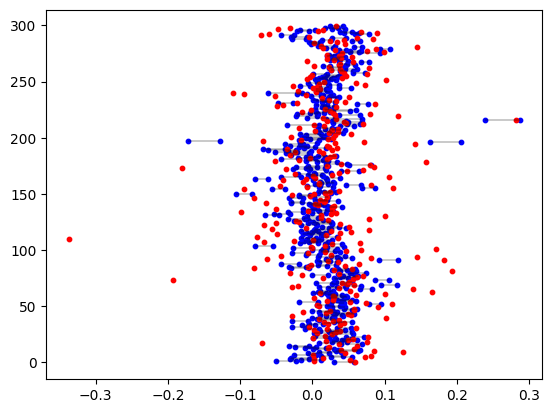

In [15]:
plt.scatter(lowers, list(range(len(yhat))), color="blue", s=10)
plt.scatter(uppers, list(range(len(yhat))), color="blue", s=10)
plt.scatter(real_y, list(range(len(yhat))), color="red", s=10)
for index in range(len(yhat)):
    plt.plot([lowers[index],uppers[index]],[index,index],'k-', linewidth=.3)
plt.show()

# Ortiz-Bobea data

In [33]:
data = pd.read_csv("../data/ortiz-bobea/data2/regdata_preferred_case.csv")
test_data = pd.read_csv("../data/ortiz-bobea/data2/regdata_test.csv")
train_data = pd.read_csv("../data/ortiz-bobea/data2/regdata_train.csv")
ordered_country_list = list(dict.fromkeys(train_data.ISO3))
enc = OrdinalEncoder()
enc.fit(np.array(ordered_country_list).reshape(-1,1))
data["encoded_iso_id"] = [int(val) for val in enc.transform(np.array(data.ISO3).reshape(-1,1))]

/tmp/ipykernel_3690/3786652120.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data["encoded_iso_id"] = [int(val) for val in enc.transform(np.array(data.ISO3).reshape(-1,1))]


# Make dataset withholding random points

In [108]:
indices_to_drop = []
all_years = set(data.year)
for year in all_years:
    year_rows = data.loc[data.year == year]
    year_row_indices = list(year_rows.index)
    drop_from_this_year = random.sample(year_row_indices, 6)
    for index in drop_from_this_year:
        indices_to_drop.append(index)
withheld_rows = data.iloc[indices_to_drop]
data_len_before = len(data)
data_mod = data.drop(indices_to_drop)
data_mod = data_mod.reset_index(drop=True)
print(f"Removed {data_len_before - len(data_mod)} rows.")

Removed 300 rows.


In [11]:
data_mod.to_csv("../data/ortiz-bobea/data2/regdata_train.csv")

In [12]:
pd.DataFrame(withheld_rows).to_csv("../data/ortiz-bobea/data2/regdata_test.csv")

In [ ]:
pd.DataFrame(data).to_csv("../data/ortiz-bobea/data2/regdata_preferred_case_encoded_iso_id.csv")

# Delta method

In [39]:
in_range = 0
out_range = 0
lowers, uppers = [], []
real_y = []

yhat = pd.read_csv("../data/ortiz-bobea/data2/ortiz_stdp_pred.csv")
for row in enumerate(yhat.itertuples()):
    lower = row[1].lower
    upper = row[1].upper
    real_y.append(row[1].fd_log_tfp)
    if lower <= real_y[-1] and upper >= real_y[-1]:
        in_range += 1
    else:
        out_range += 1
    lowers.append(lower), uppers.append(upper)

print(in_range / len(yhat))
print(out_range / len(yhat))

0.37962962962962965
0.6203703703703703


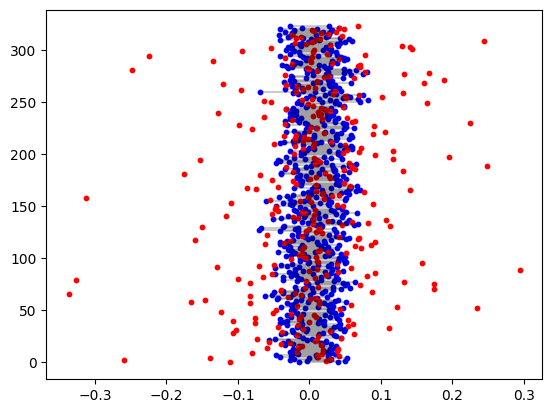

In [40]:
plt.scatter(lowers, list(range(len(yhat))), color="blue", s=10)
plt.scatter(uppers, list(range(len(yhat))), color="blue", s=10)
plt.scatter(real_y, list(range(len(yhat))), color="red", s=10)
for index in range(len(yhat)):
    plt.plot([lowers[index],uppers[index]],[index,index],'k-', linewidth=.3)
plt.show()

# Bootstrap model from R

In [76]:
bootstrap_data = pd.read_csv("../data/ortiz-bobea/data2/ortiz-bootstrap-2-years-withheld.csv")

In [95]:
bootstrap_data

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V991,V992,V993,V994,V995,V996,V997,V998,V999,V1000
0,fd_tmean,3.289076e-03,-1.370186e-02,-3.132441e-03,-1.015742e-02,-6.931133e-03,-5.469549e-03,-1.199438e-02,-1.197357e-03,-6.196749e-04,...,-9.663872e-03,-1.161915e-02,-6.527147e-03,-6.142251e-03,-1.162655e-02,-4.499969e-03,4.318363e-03,9.006270e-04,-1.278046e-05,-4.792511e-03
1,fd_tmean_sq,-2.692822e-04,1.501802e-04,-1.763931e-04,6.592168e-05,-3.455810e-05,9.758710e-06,1.045047e-04,-1.381420e-04,-1.829998e-04,...,4.761240e-05,1.026702e-04,-2.375010e-05,-7.407821e-05,1.377640e-04,-9.368356e-05,-3.208511e-04,-2.600290e-04,-1.922279e-04,-3.183785e-05
2,fd_prcp,1.452385e-04,1.913915e-04,2.231023e-04,1.164219e-04,1.795181e-04,2.143084e-04,1.930822e-04,1.935576e-04,2.630718e-04,...,1.932423e-04,1.975461e-04,1.569617e-04,1.292748e-04,1.873167e-04,1.940493e-04,1.678672e-04,1.425452e-04,8.981105e-05,2.560564e-04
3,fd_prcp_sq,-1.523281e-07,-1.781068e-07,-2.545762e-07,-1.041037e-07,-1.653965e-07,-2.081171e-07,-2.011327e-07,-1.972941e-07,-2.823311e-07,...,-2.086525e-07,-1.827401e-07,-1.521158e-07,-1.496929e-07,-1.933785e-07,-1.826971e-07,-1.653563e-07,-1.474798e-07,-8.077690e-08,-2.581454e-07


In [77]:
bootstrap_coef_vals = {}
for row in bootstrap_data.itertuples():
    bootstrap_coef_vals[row[1]] = []
    for i in range(2,1002):
        bootstrap_coef_vals[row[1]].append(row[i])

In [78]:
bootstrap_coef1 = bootstrap_coef_vals["fd_tmean"]b
bootstrap_coef2 = bootstrap_coef_vals["fd_tmean_sq"]
bootstrap_coef3 = bootstrap_coef_vals["fd_prcp"]
bootstrap_coef4 = bootstrap_coef_vals["fd_prcp_sq"]

In [82]:
in_range = 0
out_range = 0
predictions = []
real_y = []
for row in withheld_rows:
    temp = row.tmean
    temp2 = row.tmean_sq
    precip = row.prcp
    precip2 = row.prcp_sq
    real_y.append(row.fd_log_tfp)
    predict_tfp = (temp * np.array(bootstrap_coef1)) + (temp2 * np.array(bootstrap_coef2)) + (precip * np.array(bootstrap_coef3)) + (precip2 * np.array(bootstrap_coef4))
    predictions.append(sorted(predict_tfp))

In [83]:
in_range, out_range = 0, 0
interval0, interval1 = [], []
for index, prediction in enumerate(predictions):
    interval = interval = np.quantile(prediction,[.05,.95])
    interval0.append(interval[0])
    interval1.append(interval[1])
    if real_y[index] >= interval[0] and real_y[index] <= interval[1]:
        in_range += 1
    else:
        out_range += 1
print(in_range/len(predictions))
print(out_range/len(predictions))

0.311046511627907
0.688953488372093


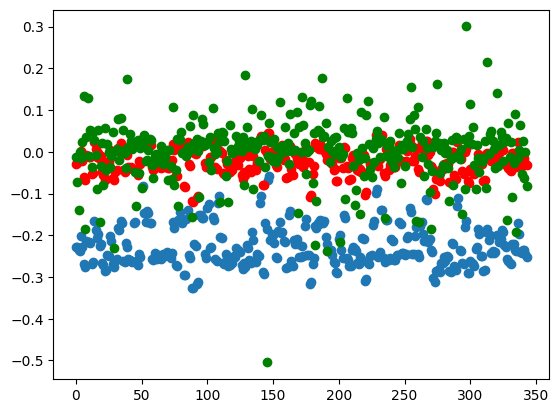

In [85]:
plt.scatter(list(range(len(predictions))), interval0)
plt.scatter(list(range(len(predictions))), interval1, color="red")
plt.scatter(list(range(len(predictions))), real_y, color="green")
plt.show()

# Bootstrap model from Stata

In [48]:
bootstrap_reps = pd.read_csv("../data/ortiz-bobea/data2/bootstrap/ortiz_stata_bootstrap_withheld.csv")
column_names = list(bootstrap_reps.iloc[0])
for index, column in enumerate(column_names):
    if "year" in column:
        column_names[index] = column.split("[")[1].split(".")[0].replace("b","")
    elif "isoxtim" in column:
        column_names[index] = column.split("[")[1].split("]")[0].replace("o.","")
    elif "encoded_iso_id" in column:
        column_names[index] = ordered_country_list[int(column.split("[")[1].split(".")[0].replace("b",""))]
    elif "_b" in column:
        if "cons" in column:
            column_names[index] = "intercept"
        else:
            column_names[index] = column.replace("_b[","").replace("]","")
bootstrap_reps.iloc[0] = column_names
bootstrap_reps.to_csv("../data/ortiz-bobea/data2/bootstrap/ortiz_stata_bootstrap_withheld_better_column_names.csv")

In [123]:
bootstrap_reps = pd.read_csv("../data/ortiz-bobea/data2/bootstrap/ortiz_stata_bootstrap_withheld_better_column_names.csv", header=1)

yhat = []
real_y = []
for row in test_data.iterrows():
    temp = row[1].fd_tmean
    temp2 = row[1].fd_tmean_sq
    precip = row[1].fd_prcp
    precip2 = row[1].fd_prcp_sq
    country = row[1].ISO3
    year = row[1].year
    real_y.append(row[1].fd_log_tfp)
    predict_tfp = (
        temp*bootstrap_reps["fd_tmean"] + 
        temp2*bootstrap_reps["fd_tmean_sq"] +
        precip*bootstrap_reps["fd_prcp"] +
        precip2*bootstrap_reps["fd_prcp_sq"] +
        bootstrap_reps[country] +
        bootstrap_reps[str(year)] +
        bootstrap_reps["intercept"]
    )
    yhat.append(sorted(predict_tfp))

In [124]:
in_range, out_range = 0, 0
lowers, uppers = [], []
for index, prediction in enumerate(yhat):
    interval = np.quantile(prediction,[.05,.95])
    lowers.append(interval[0])
    uppers.append(interval[1])
    if real_y[index] >= interval[0] and real_y[index] <= interval[1]:
        in_range += 1
    else:
        out_range += 1
print(in_range/len(yhat))
print(out_range/len(yhat))

0.2962962962962963
0.7037037037037037


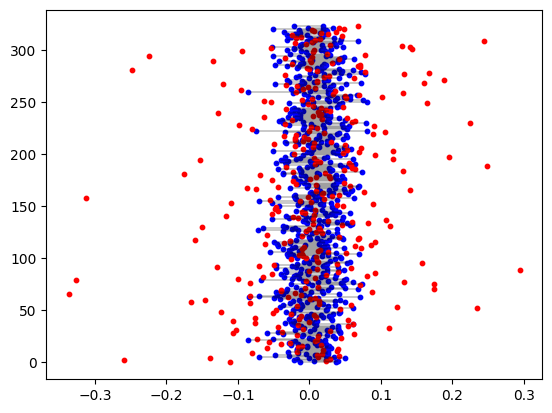

In [125]:
plt.scatter(lowers, list(range(len(yhat))), color="blue", s=10)
plt.scatter(uppers, list(range(len(yhat))), color="blue", s=10)
plt.scatter(real_y, list(range(len(yhat))), color="red", s=10)
for index in range(len(yhat)):
    plt.plot([lowers[index],uppers[index]],[index,index],'k-', linewidth=.3)
plt.show()

# Bayesian model

In [4]:
model = pd.read_pickle('../models/nature_reproduction/ortiz-bobea-reproduction-year-country-fixed-effects-deterministic-observed-withheld.pkl')
trace = model["trace"]

In [5]:
bayes_coef1 = trace.posterior.fd_temp_tfp_coef.data.flatten()
bayes_coef2 = trace.posterior.fd_sq_temp_tfp_coef.data.flatten()
bayes_coef3 = trace.posterior.fd_precip_tfp_coef.data.flatten()
bayes_coef4 = trace.posterior.fd_sq_precip_tfp_coef.data.flatten()
intercept = trace.posterior.tfp_intercept.data.flatten()
country_coefs = np.transpose(np.vstack(trace.posterior.country_coefs.data))
year_coefs = np.transpose(np.vstack(trace.posterior.year_coefs.data))

In [6]:
yhat = []
real_y = []
min_year = min(train_data.year)
for row in test_data.iterrows():
# for row in train_data.iterrows():
    temp = row[1].fd_tmean
    temp2 = row[1].fd_tmean_sq
    precip = row[1].fd_prcp
    precip2 = row[1].fd_prcp_sq
    country = row[1].ISO3
    year = row[1].year
    real_y.append(row[1].fd_log_tfp)
    if country == ordered_country_list[0]:
        country_effect = 0
    else:
        country_effect = country_coefs[ordered_country_list.index(country)-1]
    if year - min_year == 0:
        year_effect = 0
    else:
        year_effect = year_coefs[year - min_year -1]
    predict_tfp = (
        temp*bayes_coef1 + 
        temp2*bayes_coef2 +
        precip*bayes_coef3 +
        precip2*bayes_coef4 +
        country_effect +
        year_effect +
        intercept
    )
    yhat.append(sorted(predict_tfp))

In [7]:
in_range, out_range = 0, 0
lowers, uppers = [], []
for index, prediction in enumerate(yhat):
    interval = np.quantile(prediction,[.05,.95])
    lowers.append(interval[0])
    uppers.append(interval[1])
    if real_y[index] >= interval[0] and real_y[index] <= interval[1]:
        in_range += 1
    else:
        out_range += 1
print(in_range/len(yhat))
print(out_range/len(yhat))

0.3950617283950617
0.6049382716049383


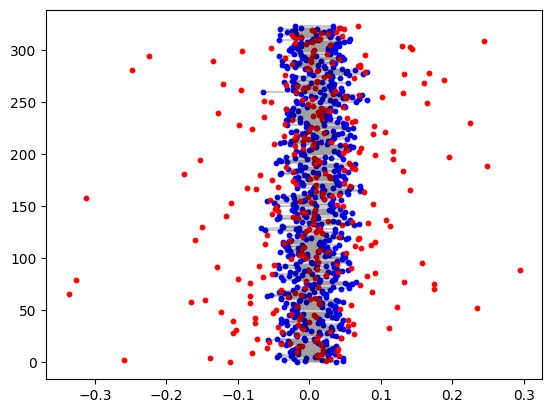

In [8]:
plt.scatter(lowers, list(range(len(yhat))), color="blue", s=10)
plt.scatter(uppers, list(range(len(yhat))), color="blue", s=10)
plt.scatter(real_y, list(range(len(yhat))), color="red", s=10)
for index in range(len(yhat)):
    plt.plot([lowers[index],uppers[index]],[index,index],'k-', linewidth=.3)
plt.show()